In [1]:
# 1. GEREKLİ KÜTÜPHANELER
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Cihaz ayarı (GPU varsa kullan)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan Cihaz: {device}")

Kullanılan Cihaz: cuda


Sınıflar: ['empty', 'occupied']
Görüntü Sayıları: [11225, 14636]


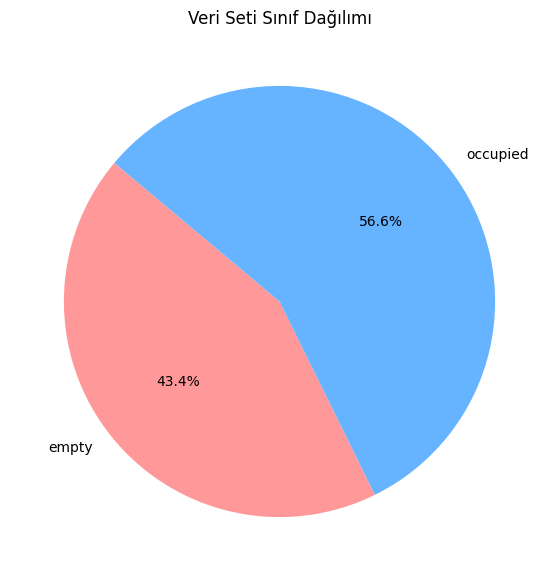

In [2]:
# 2. VERİ SETİ ANALİZİ VE GÖRSELLEŞTİRME
# BURAYI DÜZENLE: Kendi veri seti yolunu tırnak içine yaz
dataset_path = r"C:\Users\edize\Final_Dataset\train" 

classes = os.listdir(dataset_path)
counts = [len(os.listdir(os.path.join(dataset_path, cls))) for cls in classes]

print(f"Sınıflar: {classes}")
print(f"Görüntü Sayıları: {counts}")

# Pasta Grafiği
plt.figure(figsize=(7, 7))
plt.pie(counts, labels=classes, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff'])
plt.title('Veri Seti Sınıf Dağılımı')
plt.show()

In [4]:
# HÜCRE 3: VERİ SETİ HAZIRLIĞI VE DATALOADER
# ==========================================
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 1. Veri Yolları (Kendi bilgisayarındaki yolu kontrol et)
# Klasör yapın şöyle olmalı: Final_Dataset -> train, valid, test
data_dir = r"C:\Users\edize\Final_Dataset" 

# 2. Veri Dönüşümleri (Augmentation ve Normalizasyon)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # Veri çeşitliliği için döndürme
    transforms.RandomRotation(10),     # Hafif döndürme
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 3. Dataset ve DataLoader Oluşturma
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_transforms)

# Batch Size: Bilgisayarın kasarsa 16 yapabilirsin, iyiyse 32 veya 64 kalsın
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes
print(f"Sınıflar: {class_names}")
print(f"Eğitim Verisi Sayısı: {len(train_dataset)}")
print(f"Doğrulama Verisi Sayısı: {len(val_dataset)}")

Sınıflar: ['empty', 'occupied']
Eğitim Verisi Sayısı: 25861
Doğrulama Verisi Sayısı: 6466


In [5]:
# HÜCRE 4: MODEL VE EĞİTİM AYARLARI
# =================================
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import time
import copy

# Cihaz ayarı
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Eğitim şu cihazda yapılacak: {device}")

# 1. ShuffleNet Modelini İndir
model = models.shufflenet_v2_x1_0(pretrained=True)

# 2. Son Katmanı Değiştir (Senin 2 sınıfın var: Empty, Occupied)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

# 3. Hiperparametreler (Raporuna bunları yazacaksın)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5 # Deneme için 5 yeterli, istersen artırabilirsin

# 4. Eğitim Fonksiyonu
def train_model(model, criterion, optimizer, num_epochs=5):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Grafikler için listeler
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Her epochta hem Train hem Validation yapılır
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Eğitim modu
                dataloader = train_loader
            else:
                model.eval()   # Değerlendirme modu
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Veri üzerinde döngü
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # İleri yayılım (Forward)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Geri yayılım (sadece train ise)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Geçmişi kaydet
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

            # En iyi modeli kopyala
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'shufflenet_yeniden_egitilen.pth') # Kaydet

    time_elapsed = time.time() - since
    print(f'\nEğitim tamamlandı: {time_elapsed // 60:.0f}dk {time_elapsed % 60:.0f}sn')
    print(f'En iyi Val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, train_loss_history, train_acc_history, val_loss_history, val_acc_history

Eğitim şu cihazda yapılacak: cuda


c:\Users\edize\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\edize\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# HÜCRE 5: EĞİTİMİ BAŞLAT
# =======================
model, t_loss, t_acc, v_loss, v_acc = train_model(model, criterion, optimizer, num_epochs=5)

Epoch 1/5
----------
train Loss: 0.0256 Acc: 0.9952
val Loss: 0.0026 Acc: 0.9994
Epoch 2/5
----------
train Loss: 0.0046 Acc: 0.9990
val Loss: 0.0068 Acc: 0.9988
Epoch 3/5
----------
train Loss: 0.0033 Acc: 0.9993
val Loss: 0.0062 Acc: 0.9978
Epoch 4/5
----------
train Loss: 0.0036 Acc: 0.9990
val Loss: 0.0013 Acc: 0.9997
Epoch 5/5
----------
train Loss: 0.0029 Acc: 0.9992
val Loss: 0.0017 Acc: 0.9995

Eğitim tamamlandı: 6dk 1sn
En iyi Val Acc: 0.999691


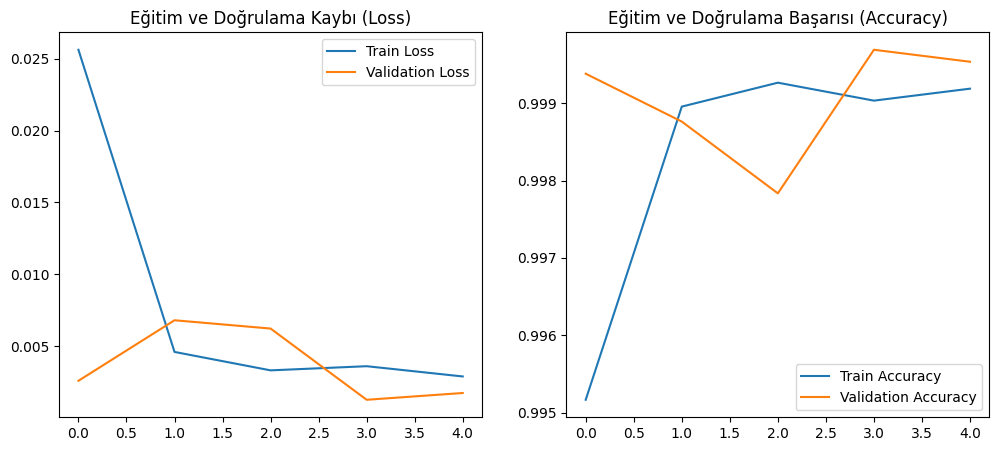

In [7]:
# HÜCRE 6: GRAFİKLERİ ÇİZDİR
# ==========================
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss Grafiği
plt.subplot(1, 2, 1)
plt.plot(t_loss, label='Train Loss')
plt.plot(v_loss, label='Validation Loss')
plt.title('Eğitim ve Doğrulama Kaybı (Loss)')
plt.legend()

# Accuracy Grafiği
plt.subplot(1, 2, 2)
plt.plot(t_acc, label='Train Accuracy')
plt.plot(v_acc, label='Validation Accuracy')
plt.title('Eğitim ve Doğrulama Başarısı (Accuracy)')
plt.legend()

plt.show()


FINAL TEST RAPORU
              precision    recall  f1-score   support

       empty     0.9993    1.0000    0.9996      2807
    occupied     1.0000    0.9995    0.9997      3659

    accuracy                         0.9997      6466
   macro avg     0.9996    0.9997    0.9997      6466
weighted avg     0.9997    0.9997    0.9997      6466



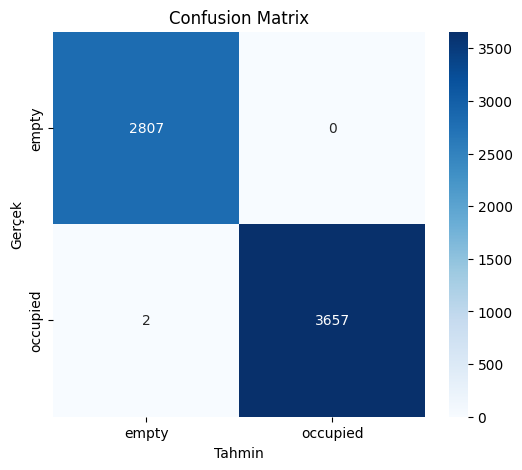

In [8]:
# HÜCRE 7: TEST SONUÇLARI VE DETAYLI RAPOR
# ========================================
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Test verisini yükle
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

y_true = []
y_pred = []

model.eval() # Test modu
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Raporu Yazdır
print("\n" + "="*30)
print("FINAL TEST RAPORU")
print("="*30)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Confusion Matrix Çizdir
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Gerçek')
plt.xlabel('Tahmin')
plt.show()

In [ ]:
# HÜCRE 8: TAHMİN ÖRNEKLERİ (GÖRSELLEŞTİRME) - GÜNCELLENMİŞ
# =========================================================
import matplotlib.pyplot as plt
import torch
import numpy as np
import os
from torchvision import models
import torch.nn as nn

# 1. Gerekli Kontroller ve Yüklemeler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = 'shufflenet_yeniden_egitilen.pth'

# Model değişkeni hafızada yoksa veya yeniden yüklemek gerekirse:
if 'model' not in globals():
    print("Model hafızada bulunamadı, yeniden oluşturuluyor...")
    try:
        from torchvision.models import ShuffleNet_V2_X1_0_Weights
        model = models.shufflenet_v2_x1_0(weights=ShuffleNet_V2_X1_0_Weights.DEFAULT)
    except:
        model = models.shufflenet_v2_x1_0(pretrained=True)
    
    # Son katmanı projeye uygun hale getir
    model.fc = nn.Linear(model.fc.in_features, 2)
    model = model.to(device)

# Eğitilmiş ağırlıkları yükle
if os.path.exists(model_path):
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Başarılı: '{model_path}' dosyasından ağırlıklar yüklendi.")
    except Exception as e:
        print(f"UYARI: Ağırlıklar yüklenirken hata oluştu: {e}")
else:
    print(f"UYARI: '{model_path}' dosyası bulunamadı! Eğitilmemiş model kullanılıyor olabilir.")

# 2. Görselleştirme Fonksiyonu
def visualize_predictions(model, dataloader, num_images=16):
    model.eval()
    
    # DataLoader kontrolü
    try:
        data_iter = iter(dataloader)
        images, labels = next(data_iter)
    except NameError:
        print("\n❌ HATA: 'val_loader' tanımlı değil!")
        print("Lütfen yukarıdaki 'HÜCRE 3: VERİ SETİ HAZIRLIĞI' hücresini çalıştırın ve tekrar deneyin.")
        return
    except Exception as e:
        print(f"\n❌ HATA: Veri yüklenemedi. Detay: {e}")
        return

    images = images.to(device)
    labels = labels.to(device)

    print("Tahminler yapılıyor...", end="")
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    print("Tamamlandı.")

    # Sınıf isimleri kontrolü
    current_class_names = globals().get('class_names', ['Sınıf 0', 'Sınıf 1'])

    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        if i >= len(images): break
        ax = plt.subplot(4, 4, i + 1)
        img = images[i].cpu().permute(1, 2, 0).numpy()
        # Denormalize
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        
        true_label = current_class_names[labels[i]]
        pred_label = current_class_names[preds[i]]
        
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.savefig('tahmin_ornekleri.png')
    plt.show()
    print("\n✅ Başarılı! Grafik 'tahmin_ornekleri.png' olarak kaydedildi ve ekrana basıldı.")

# 3. Çalıştır
if 'val_loader' in globals():
    visualize_predictions(model, val_loader)
else:
    print("\n⚠️ UYARI: 'val_loader' bulunamadı.")
    print("Lütfen önce 'HÜCRE 3' (Veri Seti) hücresini çalıştırın, sonra bu hücreyi tekrar çalıştırın.")
